<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Simulating_Plucked_Strings_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Karplus-Strong model

Here's the schematic of the Karplus-Strong model of string synthesis, borrowed from [Wikipedia](https://en.wikipedia.org/wiki/Karplus–Strong_string_synthesis). It is designed to simulate the sound of a plucked string. It is not for simulating bowed strings.

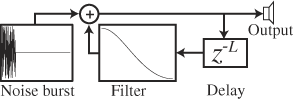

The idea is that the string is instantiated into a random state by plucking. Following the wave equation, the wave proceeds down the length of the string, reflects, travels back up the string, reflects again, and ends up back where it started, with a delay. The original wave and all of its delayed copies are summed and that's the result of the simulation. In addition, there is some damping of the waves, in particular high frequency waves are damped more. So each time round the "loop" a low-pass filter is applied.

# But it's Serial :(

Unfortunately this algorithm, as described, is inherently a serial algorithm. You're always feeding its own output back into iself.

Infinite impulse response (IIR) filters also appear to be serial in this way, but I've previously shown how these can be made parallel with parallel prefix scan. This works because if an IIR filter has a width of $N$ coefficients, you can think of the state of the filter at any moment as described by $N$ real numbers representing the last $N$ samples passed through. The update of the state from one sample to the next is represented by an $N\times N$ matrix and matrix multiplication is associative meaning parallel prefix applies.

Karplus-Strong is essentially an IIR filter applied to a noise burst. But it's a long filter, around the length of the delay. If we're working at 44KHz and want to play the note A4, the delay will be 100 samples. That requires roughly a $100\times 100$ matrix for every sample. That's not a reasonable amount of data to work with.

So I set myself the puzzle of finding another way.

# Some Filter Algebra

Let $D_L$ be a linear operator representing an $L$-sample delay, and let $F$ be some low-pass filter.

If $x$ is the entire input noise signal and $y$ is the output then reading the schematic above gives $y = x + D_LFy$. So
$$y = (1-D_LF)x.$$

One way to approach this is via a Taylor series:
$$y = y + D_LFy+D_{2L}F^2y + D_{3L}F^3y\ldots.$$
This has the explanation that the output is the original signal, plus the original delayed and filtered, plus the signal delayed and filtered twice and so on. This doesn't help much, taking it literaly requires us to sum many terms.

But here's a trick: Every integer $\ge0$ can be written uniquely as a sum of powers of two. That's the basis for binary arithmetic. So we can write
$$
  y=(1+D_LF)(1+D_{2L}F^2)(1+D_{4L}F^4)\ldots(1+D_{2^iL}F^{2^i})\ldots y
$$
This allows us to sum $2^n$ terms of the Taylor series by applying just $n$ individual filters.

But there's still a catch: although $D_{2^iL}$ is easy to compute, it's just a long delay, $F^{2^i}$ requires $2^i$ applications of the filter $F$ and that's not cheap.

# Repeated Convolutions Give a Gaussian

So here's another trick: if you apply a filter $F$, whose coefficients sum to 1, enough times, it eventually becomes indistinguishable from a Gaussian filter. If we view the filter coefficients as a discrete probability distribution with variance $\sigma^2$ then for large $N$, $F^N$ has coefficients close to a Gaussian filter with variance $N\sigma^2$.

In fact, if we know we're eventually going to have $F^{2^i}$ turn into a Gaussian, it's convenient to pick $F$ to be a Gaussian filter in the first place.

But Gaussians are still expensive to compute, they're infinitely wide filters.

So one last trick: because repeated convolution of any positive filter gives a Gaussian we can approximate a Gaussian as $n$ iterations of a box filter with appropriate variance. A box filter can be evaluated efficiently on a GPU.

And now we have a complete algorithm for Karplus-Strong we can implement in TensorFlow.

# The Code Begins

First some imports

In [ ]:
import numpy as np
from IPython.display import Audio
import tensorflow as tf
import tensorflow_probability as tfp
import collections
import matplotlib.pyplot as plt
tfd = tfp.distributions

# Not quite a Box

One problem with a box filter is that it is completely described by its width, an integer. This doesn't give us much leeway to design a filter with an exactly specified variance. So I tweak the filter slightly so that its a box (of odd width) with coefficients $b$ and with an extra $a$ on each side. So the table of coefficients looks like

($a$, $b$, $b$, $\ldots w$ $b$'s in total $\ldots$, $b$, $a$)

I did some algebra to compute suitable values for $w$, $a$ and $b$ which is too boring to describe here. (If enough people ask I'll write an appendix.) Here's the code:

In [ ]:
# Filter with a box filter with extra coefficients tacked onto each end.
def bordered_box(w, a, b, x):
  half_w = (w + 1) // 2
  x = tf.pad(x, [[half_w, half_w]])
  s = tf.cumsum(x, axis=0)  # `cumsum` is fast and gives a box filter.
  return b * (s[w:-1] - s[:-w - 1]) + a * (x[w + 1:] + x[:-w-1])

In [ ]:
# Compute suitable width of filter
def width(sigma):
  return 1 + 2 * int(0.5 * np.sqrt(1 + 12 * sigma**2) - 1)

# For fixed `sigma` and `width` the values of `a` and `b` are fixed.
def weights(sigma, w):
  return ((1 - w**2 + 12 * sigma**2)/(8 + 12 * w + 4 * w**2),
          3 * (1 + 2 * w + w**2 - 4 * sigma**2) / (2 * w * (1 + w) * (2 + w)))

In [ ]:
def fake_gaussian(n, sigma, x):
  sigma = sigma / tf.sqrt(1.0 * n)
  w = width(sigma)
  a, b = weights(sigma, w)

  for i in range(n):
    x = bordered_box(w, a, b, x)

  return x

Just in case you don't believe, here's an example of `fake_gaussian` in use. I apply it to a signal with a single non-zero sample so the result is the signal consisting of the filter coefficients. I compare with the exact Gaussian. If you set $n$ to 20 you get a good match but I think $n=4$ is good enough for our needs.

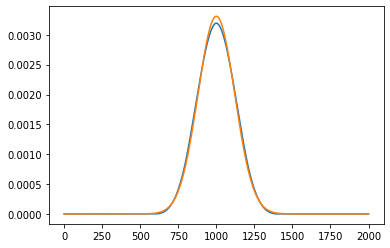

In [ ]:
sigma = 120.5
n = 4     # Try setting n to 20
m = 1000  # Width of test data
x = tf.concat([tf.zeros(m), [1], tf.zeros(m)], axis=0)

x = fake_gaussian(n, sigma, x)

plt.plot(x)
plt.plot(1 / (np.sqrt(2 * np.pi) * sigma) * tf.exp(-(tf.range(2 * m + 1.) - m)**2 / (2 * sigma**2)))

In [ ]:
# Integer delay. I've skipped fractional delays.
# If you want fractional delays, Lagrange interpolation is
# probably a good choice.
def delay(x, n): # assume n > 0
  return tf.concat([tf.zeros(n), x[:-n]], axis=0)


# Results

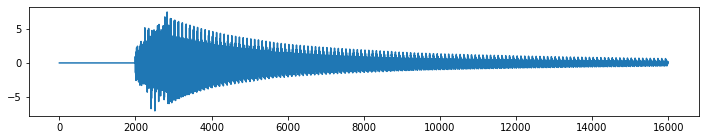

In [ ]:
rate = 44000
T = 2  # Number of seconds to synthesise.
D = 100  # The pitch is rate/D. D in [30, 600] works fine.
# Initial noise pulse
x = tf.concat([
    tfd.Normal(loc=0., scale=1.).sample(1000),
    tf.zeros(T * rate - 100)
    ], axis=0)

# This is the loop described in the equationa above.
# I also added an attenuation control `decay`.
sigma = 0.2  # [0.01, 5] seems like a good range.
decay = 0.99  # Should lie in range [0, 1)
for i in range(8):
  # Note the 0.5 in the line below. This is because convolving a filter
  # of standard deviation `sigma` with itself `N` times gives a filter of
  # standard deviation `sqrt(N) * sigma`.
  x = x + decay ** (2 ** i) * fake_gaussian(4, 2 ** (0.5 * i) * sigma, delay(x, 2 ** i * D))
plt.figure(figsize=(12,2))
x = tf.concat([tf.zeros(2000), x], axis=0)
plt.plot(x[0:16000])

# There seems to be a bug in colab. When you hit 'play' the first part of the
# signal seems to get swallowed. So I play 4 copies.
Audio(tf.tile(x, [4]), rate=rate)

# Conclusions

It seems to produce similar results to the example on Wikipedia so I pronounce this a success.

But there are some areas where this approach fails:

1. We can't dynamically vary the parameters during playing. This is OK for plucking a fixed string but we can't do any pitch bending.
2. There's still quite a bit of work involved in synthesising a sample. If you're GPU is 1000x faster than your CPU it's worth it. But if your GPU is only 30x faster it might not be.